# Trabajo Final. Análisis de Datos

## Alumnos:

### Domenje, Carlos R.

### Fux, Santiago.

---

## DATASET: Uso de Taxis Yellow Cab en USA en el año 2020

**Problema.** Responderemos a la siguiente pregunta

1. ¿Existe una manera de caracterizar los lugares más recurrentes para inicio / fin de viaje?


## 1. Obtención de datos

Para importar los datos, buscamos en la página web brindada por la cátedra:

- [Yellow Cab - Dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

**Nota**: El dataset utilizado será el del año 2020, los tres primeros meses (Enero, Febrero, Marzo) y será descargado en una carpeta llamada "data" dentro de la carpeta contenedora del proyecto.

In [261]:
# Path del dataset a utilizar.
DATASET_PATH = r'./data'

In [262]:
# listamos los archivos que se encuentran en el path
!ls {DATASET_PATH}

yellow_tripdata_2020-01.parquet  yellow_tripdata_2020-03.parquet
yellow_tripdata_2020-02.parquet


In [263]:
# Importamos las librerias necesarias para interactuar con el dataset.

import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; 
import scipy.stats as stats
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from collections import Counter
# Set decimals format with 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [264]:
# El archivo del dataset tiene como formato .parquet, el cual es un archivo que esta orientado a columnas. 
all_files = glob.glob("./data/*.parquet")

df_list = []

for filename in all_files:
    # Se carga el archivo
    df_all = pd.read_parquet(filename)
    # Tomo el 10% del dataset total   
    df_all = df_all.sample(frac=0.1)
    # Agrego a la lista
    df_list.append(df_all)


df_all = pd.concat(df_list, axis=0, ignore_index=True)


df_all.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1571207.000,1555902.000,1571207.000,1555902.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1555902.000
mean,1.673,1.502,2.875,1.056,164.495,162.268,1.252,12.599,1.106,0.492,2.190,0.330,0.298,18.542,2.298
std,0.470,1.143,14.170,0.745,65.701,69.986,0.486,12.580,1.254,0.077,2.663,1.584,0.035,14.989,0.704
min,1.000,0.000,-27.270,1.000,1.000,1.000,0.000,-450.000,-27.000,-0.500,-91.000,-35.740,-0.300,-477.800,-2.500
25%,1.000,1.000,0.970,1.000,125.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,11.160,2.500
50%,2.000,1.000,1.600,1.000,162.000,162.000,1.000,9.000,0.500,0.500,1.950,0.000,0.300,14.300,2.500
75%,2.000,2.000,2.930,1.000,234.000,234.000,2.000,14.000,2.500,0.500,2.860,0.000,0.300,19.800,2.500
max,6.000,9.000,17137.170,99.000,265.000,265.000,4.000,6052.000,52.500,30.800,333.330,190.000,0.300,6061.420,2.750


In [265]:
manhattan_codes = [4,12,13,24,41,42,43,45,48,50,68,74,75,79,87,88,90,100,103,104,105,107,113,114,116,120,125,127,128,137,140,141,142,143,144,148,151,152,153,158,161,162,163,164,166,170,186,194,202,209,211,224,229,230,231,232,233,234,236,237,238,239,243,244,246,249,261,262,263]

In [266]:
df = df_all.query(f'PULocationID in {manhattan_codes} & DOLocationID in {manhattan_codes}')

In [267]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1344099.000,1341137.000,1344099.000,1341137.000,1344099.000,1344099.000,1344099.000,1344099.000,1344099.000,1344099.000,1344099.000,1344099.000,1344099.000,1344099.000,1341137.000
mean,1.669,1.504,1.845,1.013,167.005,165.777,1.250,9.600,1.127,0.496,1.826,0.009,0.298,14.966,2.415
std,0.471,1.146,1.451,0.527,66.040,67.988,0.465,5.714,1.239,0.065,1.736,0.349,0.033,6.805,0.490
min,1.000,0.000,-14.940,1.000,4.000,4.000,0.000,-300.000,-27.000,-0.500,-91.000,-11.750,-0.300,-303.300,-2.500
25%,1.000,1.000,0.900,1.000,116.000,114.000,1.000,6.000,0.000,0.500,0.000,0.000,0.300,10.800,2.500
50%,2.000,1.000,1.430,1.000,163.000,162.000,1.000,8.500,0.500,0.500,1.880,0.000,0.300,13.560,2.500
75%,2.000,2.000,2.300,1.000,234.000,234.000,1.000,11.500,2.500,0.500,2.660,0.000,0.300,17.300,2.500
max,2.000,8.000,82.700,99.000,263.000,263.000,4.000,480.000,8.250,30.800,333.330,190.000,0.300,498.660,2.750


In [268]:
## Para obtener una descripción del tipo de datos que contiene cada columna, utilizamos la funcion info()
# Podemos además, obtener una idea general de cuantos datos no nulos contiene.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1344099 entries, 0 to 1571206
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1344099 non-null  int64         
 1   tpep_pickup_datetime   1344099 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1344099 non-null  datetime64[ns]
 3   passenger_count        1341137 non-null  float64       
 4   trip_distance          1344099 non-null  float64       
 5   RatecodeID             1341137 non-null  float64       
 6   store_and_fwd_flag     1341137 non-null  object        
 7   PULocationID           1344099 non-null  int64         
 8   DOLocationID           1344099 non-null  int64         
 9   payment_type           1344099 non-null  int64         
 10  fare_amount            1344099 non-null  float64       
 11  extra                  1344099 non-null  float64       
 12  mta_tax                13440

### Descripción de Columnas del Dataset.


In [269]:
# Listado de tipos de variables presentes en el dataset
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                      object
dtype: object

In [270]:
# funcion para plotear las distribuciones de los atributos
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=10, ylabelsize=10,figsize=(18,18))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout
    plt.show()
    

# funcion para imprimir nulos
def print_null_info(col):
    print(f'Cantidad de nulos: {col.isnull().sum()}/{col.size}')

# funcion para imprimir datos de v. categoricas
def print_categorical(col):
    print(f'Ordinalidad: {col.unique()}')
    print_null_info(col)
    print('Ocurrencias:')
    print(col.value_counts().sort_values())

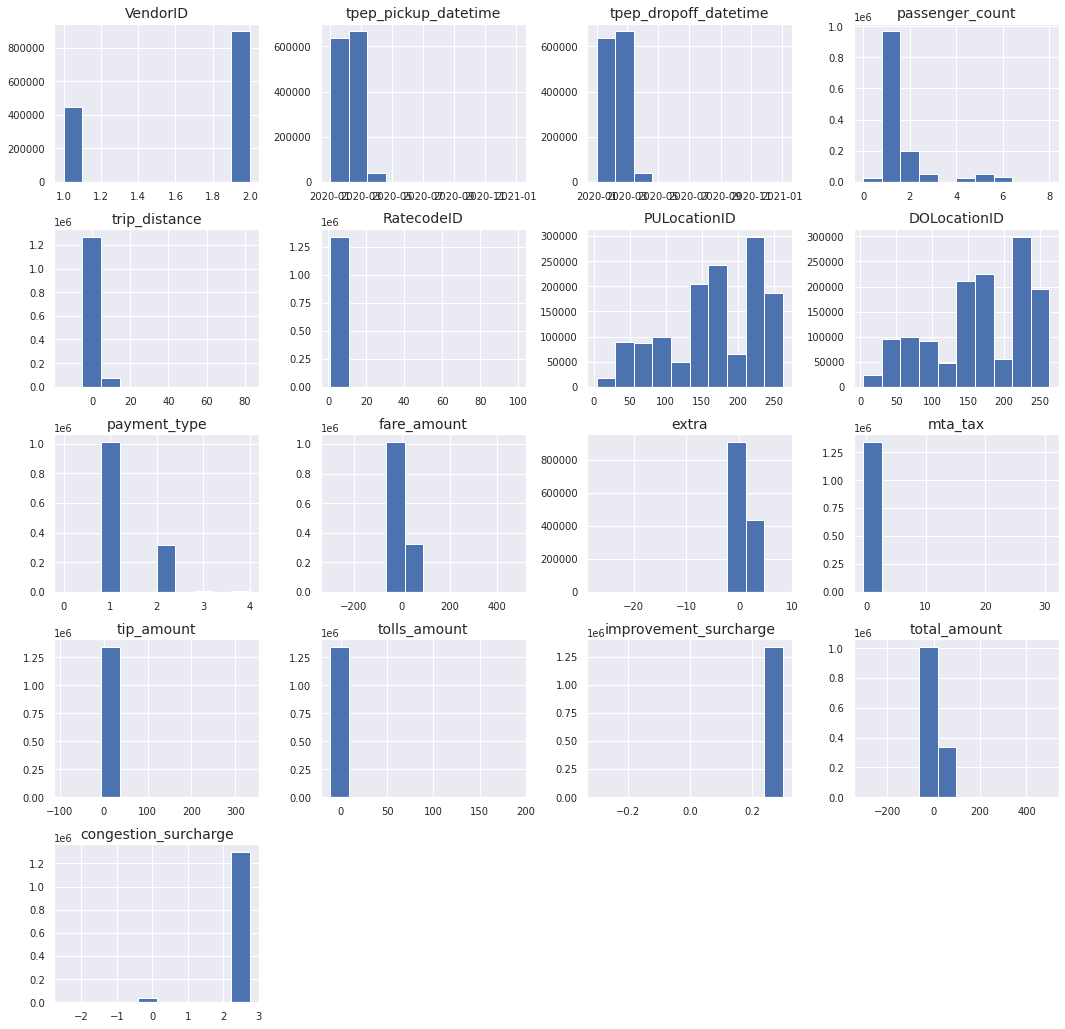

In [271]:
#imprimo distribuciones 
display_dataset_distributions(df)


- **VendorID**: Proveedor de servicios de tecnologias en taxis (T-PEP)
    - Tipo de dato: Categórica ordinal  
    - Tipo de variable: Entrada  


In [272]:
print_categorical(df.VendorID)

Ordinalidad: [2 1]
Cantidad de nulos: 0/1344099
Ocurrencias:
1    445311
2    898788
Name: VendorID, dtype: int64



- **tpep_pickup_datetime**: Fecha y hora en el cual el reloj fue activado al iniciar un viaje.
    - Tipo de dato: Timestamp compuesto  
    - Tipo de variable: Entrada  

    - Ejemplo del dato en el dataset: 2020-07-01 00:25:32


In [273]:
print_null_info(df.tpep_pickup_datetime)

Cantidad de nulos: 0/1344099


- **tpep_dropoff_datetime**: Fecha y hora en el cual el reloj fue desactivador al finalizar un viaje.
    - Tipo de dato: Timestamp compuesto
    - Tipo de variable: Entrada  / Salida

    - Ejemplo del dato en el dataset: 2020-07-01 00:33:39


In [274]:
print_null_info(df.tpep_dropoff_datetime)

Cantidad de nulos: 0/1344099


- **passenger_count**: El número de pasajeros en el vehiculo. (Es un dato que lo ingresa el conductor.)
    - Tipo de dato: Numérico 
    - Tipo de variable: Entrada
    - Ejemplo del dato en el dataset: 1.0

In [275]:
print_null_info(df.passenger_count)

Cantidad de nulos: 2962/1344099



- **trip_distance**: La distancia del viaje transcurrido en millas reportada por el taxímetro. 
    - Tipo de dato: Numérico 
    - Tipo de variable: Entrada  

    - Ejemplo del dato en el dataset: 1.50


In [276]:
print_null_info(df.trip_distance)

Cantidad de nulos: 0/1344099


- **PULocationID**: TLC Zona en la que el taxímetro se activó.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada / Salida

    - Ejemplo del dato en el dataset: 238


In [277]:
print_categorical(df.PULocationID)

Ordinalidad: [113 230 261 231 151 237 137 186 144 163 162 141 236  79 234 143 164  68
 161  87  48 238 107 170   4 239 140 263 246 125 211 100  43  90 114 233
 142 249  13  74 229 148 262 166  41  75  24 152 116 232 158 209  50  42
  12 127 243 224  88  45 244 153 194 202 120 128]
Cantidad de nulos: 0/1344099
Ocurrencias:
128        6
120        8
153       10
202       26
194       82
       ...  
186    52190
162    53327
161    62968
236    63994
237    67677
Name: PULocationID, Length: 66, dtype: int64



- **DOLocationID**: TLC Zona en la que el taxímetro se desactivó.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada / Salida 

    - Ejemplo del dato en el dataset: 75


In [278]:
print_categorical(df.DOLocationID)

Ordinalidad: [ 79 186 113  43 107  87 246 148 233 141 229 238 162 151 100 237 234 144
 163 161 239 231 170  88 140  90 142 236  48  13 249 263   4 158 230 164
 261  68 143 262 211  74 137 116  75 166 232 224 114  50 244  24  42 243
 125 194  41 152 127 209  45 202  12 153 120 128 105]
Cantidad de nulos: 0/1344099
Ocurrencias:
105        1
120       54
153       71
128       76
194      106
       ...  
162    44370
170    46202
161    57949
237    61759
236    68352
Name: DOLocationID, Length: 67, dtype: int64



- **RatecodeID**:  El código de tarifa final vigente al final del viaje.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada  

    - 1= Standard rate
    - 2= JFK 
    - 3= Newark
    - 4= Nassau or Westchester
    - 5= Negotiated fare
    - 6= Group ride


In [279]:
print_categorical(df.RatecodeID)

Ordinalidad: [ 1.  2. nan  5.  3. 99.  4.  6.]
Cantidad de nulos: 2962/1344099
Ocurrencias:
6.000           2
4.000          25
99.000         34
3.000         247
2.000        2592
5.000        2671
1.000     1335566
Name: RatecodeID, dtype: int64


- **store_and_fwd_flag**:  Este flag indica si el registro de viaje se llevó a cabo en la memoria del dispositivo del vehiculo antes de enviar al proveedor, también conocido como "almacenar y reenviar", porque el vehiculo no tenia conexion al servidor.
    - Tipo de dato: Categórica  
    - Tipo de variable: Entrada  

    - Y= Almacenar y reenviar informacion.
    - N= No almacenar y enviar informacion.


In [280]:
print_categorical(df.store_and_fwd_flag)

Ordinalidad: ['N' 'Y' None]
Cantidad de nulos: 2962/1344099
Ocurrencias:
Y      13072
N    1328065
Name: store_and_fwd_flag, dtype: int64



- **payment_type**: Un código numérico que significa cómo el pasajero pagó por el viaje.
    - Tipo de dato: Categórica ordinal  
    - Tipo de variable: Entrada  

    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip


In [281]:
print_categorical(df.payment_type)

Ordinalidad: [1 2 3 0 4]
Cantidad de nulos: 0/1344099
Ocurrencias:
0       2962
4       3467
3       5810
2     317055
1    1014805
Name: payment_type, dtype: int64


- **fare_amount**: La tarifa de tiempo y distancia calculada por el taxímetro.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 8.0


In [282]:
print_null_info(df.fare_amount)

Cantidad de nulos: 0/1344099


- **Extra**: Varios extras y recargos. Actualmente, esto solo incluye los cargos de $0.50 y $1 por la hora pico y por la noche.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.5


In [283]:
print_null_info(df.extra)

Cantidad de nulos: 0/1344099



- **mta_tax**: Impuesto MTA de $0.50 que se activa automáticamente según la tasa de uso del medidor.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.5


In [284]:
print_null_info(df.mta_tax)

Cantidad de nulos: 0/1344099


- **improvement_surcharge**: Recargo de mejora de $ 0.30 en viaje en el descenso de bandera. El recargo por mejora comenzó a cobrarse en 2015.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.3


In [285]:
print_null_info(df.improvement_surcharge)

Cantidad de nulos: 0/1344099


- **tip_amount**: Importe de la propina: este campo se completa automáticamente para las propinas de tarjetas de crédito. Las propinas en efectivo no están incluidas.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.00  


In [286]:
print_null_info(df.tip_amount)

Cantidad de nulos: 0/1344099


- **tolls_amount**: Importe total de todos los peajes pagados en el viaje.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 0.00


In [287]:
print_null_info(df.tolls_amount)

Cantidad de nulos: 0/1344099



- **total_amount**: El monto total cobrado a los pasajeros. No incluye propinas en efectivo.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 9.30


In [288]:
print_null_info(df.total_amount)

Cantidad de nulos: 0/1344099


- **congestion_surcharge**: Importe total recaudado en el viaje por el recargo por congestión del Estado de Nueva York.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 0.00


In [289]:
print_null_info(df.congestion_surcharge)

Cantidad de nulos: 2962/1344099


- **airport_fee**: $1.25 para recoger solo en los aeropuertos LaGuardia y John F. Kennedy
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida
    - Ejemplo del dato en el dataset: None

In [290]:
print_null_info(df.airport_fee)

Cantidad de nulos: 1344099/1344099


## 2. Limpieza de los datos


### 2.1 Datos faltantes

In [291]:
# verificamos cantidad de nulos en cada categoría
for i in range(len(df.columns)):
  col_name = df.columns[i]
  col_data = df[col_name]
  print(f'{col_name}: {col_data.isnull().sum()}/{col_data.size}')

VendorID: 0/1344099
tpep_pickup_datetime: 0/1344099
tpep_dropoff_datetime: 0/1344099
passenger_count: 2962/1344099
trip_distance: 0/1344099
RatecodeID: 2962/1344099
store_and_fwd_flag: 2962/1344099
PULocationID: 0/1344099
DOLocationID: 0/1344099
payment_type: 0/1344099
fare_amount: 0/1344099
extra: 0/1344099
mta_tax: 0/1344099
tip_amount: 0/1344099
tolls_amount: 0/1344099
improvement_surcharge: 0/1344099
total_amount: 0/1344099
congestion_surcharge: 2962/1344099
airport_fee: 1344099/1344099


#### 2.1.1 Análisis de faltantes

Las categorías con faltantes son las siguientes:

* passenger_count: 15180/1571072
* RatecodeID: 15180/1571072
* store_and_fwd_flag: 15180/1571072
* congestion_surcharge: 15180/1571072
* airport_fee: 1571072/1571072

Para cada una de estas columnas se decide:
* __passenger_count__ es ingresado a mano por lo que los datos faltantes suponemos que corresponden a fallas en la carga por parte del conductor. Se decide eliminar los faltantes dado que representan el 1%
* __RatecodeID__ no aporta información por lo que se elimina esta feature
* __store_and_fwd_flag__ no aporta información por lo que se elimina esta feature
* __congestion_surcharge__ : los faltantes representan el 1% por lo que se quitan
* __airport_fee__ se quita ya que todos los valores son nulos


In [292]:
# descarto datos nulos de los features con interés (passenger count y congestion_surcharge)
df = df.dropna(subset=['passenger_count', 'congestion_surcharge'])
len(df['passenger_count'])

1341137

#### 2.1.2 Datos no nulos inválidos

En algunos features se detectan valores fuera del rango esperado (tal como valores negativos o fuera del rango de las categorías definidas)

In [293]:
# verificamos cantidad de negativos en las categorías numéricas
cols_to_check = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']

for i, col in enumerate(cols_to_check):
  col_data = df[col]
  print(f'{col}: {col_data[col_data < 0].count()}/{col_data.size}')
  

trip_distance: 0/1341137
fare_amount: 3897/1341137
extra: 1928/1341137
mta_tax: 3841/1341137
tip_amount: 10/1341137
tolls_amount: 17/1341137
improvement_surcharge: 3897/1341137
total_amount: 3897/1341137
congestion_surcharge: 3666/1341137


In [294]:
# Funcion para realizar subplots de variables

def plotVariables(dataframe, varArray):
    fig = plt.figure(figsize=(30,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for j,colName in enumerate(varArray):
        plt.subplot(3,3,j+1)
        plt.plot(dataframe[colName])
        plt.title(colName)
        

#### Exploración gráfica de variables con datos negativos

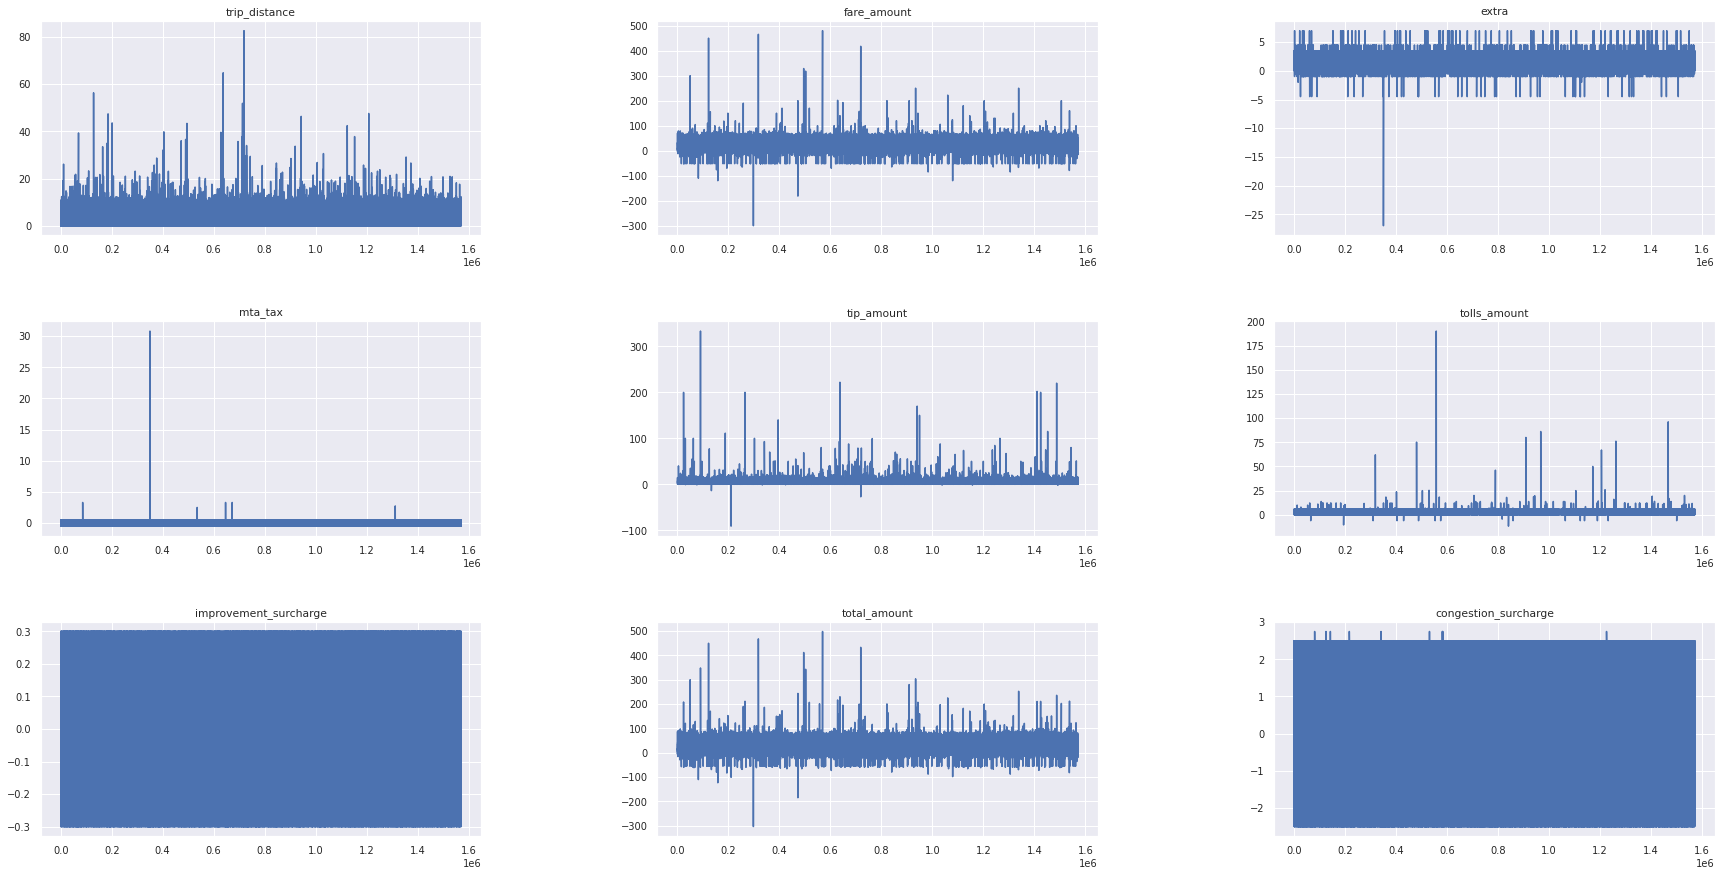

In [295]:
 #TODO: Agrego graficos para mostrar estos datos anomalos.
# Exploración gráfica de variables con datos negativos.

colArrays = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 
            'tip_amount', 'tolls_amount', 'improvement_surcharge', 
            'total_amount', 'congestion_surcharge']

plotVariables(df,colArrays)


In [296]:
# trip distance: borro <= 0
df = df[(df['trip_distance'] > 0)]
# fare_amount: borro < 0
df = df[(df['fare_amount'] >= 0)]
# extra: borro < 0
df = df[(df['extra'] >= 0)]
# mta_tax: borro < 0
df = df[(df['mta_tax'] >= 0)]
# tip_amount: borro < 0
df = df[(df['tip_amount'] >= 0)]
#tolls amount: borro < 0
df = df[(df['tolls_amount'] >= 0)]
#improvement_surcharge: borro < 0
df = df[(df['improvement_surcharge'] >= 0)]
#total_amount: borro < 0
df = df[(df['total_amount'] >= 0)]
#congestion_surcharge: borro < 0
df = df[(df['congestion_surcharge'] >= 0)]

len(df)



1331069

#### Exploración gráfica de datos filtrados


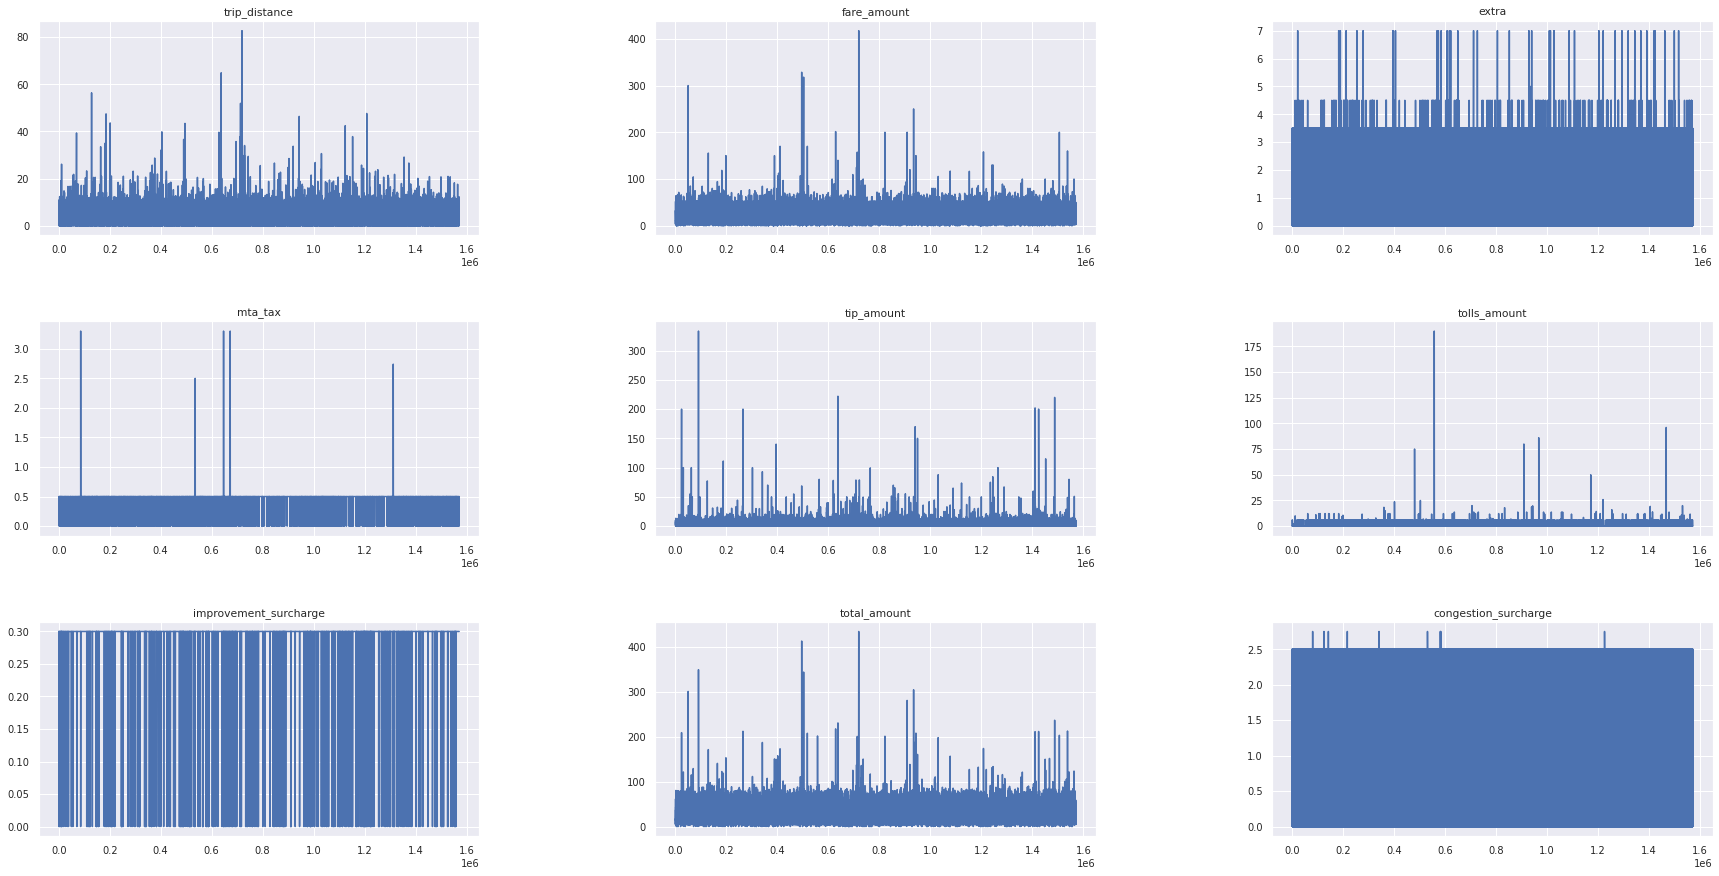

In [297]:
# Datos sin valores negativos
plotVariables(df,colArrays)

#### 2.1.3 Filtro entradas por tipo de pago
Descarto otros pagos diferenes de CREDIT (payment_type = 1)

In [298]:
df = df[df["payment_type"] == 1]
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000,1010910.000
mean,1.668,1.495,1.895,1.003,168.047,167.098,1.000,9.692,1.144,0.500,2.407,0.006,0.300,15.692,2.453
std,0.471,1.142,1.451,0.101,65.549,67.588,0.000,5.102,1.237,0.013,1.535,0.301,0.002,6.188,0.339
min,1.000,0.000,0.010,1.000,4.000,4.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.950,1.000,125.000,114.000,1.000,6.000,0.000,0.500,1.660,0.000,0.300,11.750,2.500
50%,2.000,1.000,1.500,1.000,163.000,163.000,1.000,8.500,0.500,0.500,2.160,0.000,0.300,14.160,2.500
75%,2.000,2.000,2.350,1.000,234.000,234.000,1.000,11.500,2.500,0.500,2.960,0.000,0.300,18.300,2.500
max,2.000,6.000,82.700,5.000,263.000,263.000,1.000,417.500,7.000,3.300,333.330,190.000,0.300,433.540,2.750


### 2.2 Ingeniería de datos

#### 2.2.1 Features de tiempo y hora del día

In [299]:
# generamos una nueva columna "duration" con el tiempo de viaje
ts_init = pd.to_datetime(df['tpep_pickup_datetime']).values.astype(np.int64) / 1000000000
ts_end = pd.to_datetime(df['tpep_dropoff_datetime']).values.astype(np.int64) / 1000000000
duration = ts_end - ts_init
df['duration'] = duration

# ademas creamos 3 categorías para el horario en que se inició el viaje: diurno, vespertino y nocturno
MORNING_START = 6
MORNING_END = 13
AFTERNOON_START = 14
AFTERNOON_END = 20
EVENING_START = 21
EVENING_END = 5 

day_interval = df['tpep_pickup_datetime'].dt.hour
df['morning'] = pd.cut(day_interval, bins=[-float('Inf'), MORNING_START - 1, MORNING_END, float('Inf')], labels=[0, 1, 0], ordered=False)
df['afternoon'] = pd.cut(day_interval, bins=[-float('Inf'), AFTERNOON_START - 1, AFTERNOON_END, float('Inf')], labels=[0, 1, 0], ordered=False)
df['evening'] = pd.cut(day_interval, bins=[-float('Inf'), 0, EVENING_END, EVENING_START, 23, float('Inf')], labels=[0, 1, 0, 1, 0], ordered=False)

# reviso que sean validas 
df['morning'].values.isnull().sum(), df['afternoon'].values.isnull().sum(), df['evening'].values.isnull().sum()

(0, 0, 0)

In [300]:
# termino de borrar todos los negativos
df['morning'].values.isnull().sum(), df['afternoon'].values.isnull().sum(), df['evening'].values.isnull().sum()

# verifico si tengo entradas con duration < 0
duration_invalid = df[df['duration'] < 0]['duration'].count()
print(f'Duraciones inválidas: {duration_invalid}')

Duraciones inválidas: 0


In [301]:
# Se eliminan las duraciones invalidas
df = df[(df['duration'] > 0)]

#### 2.2.2 Codificación del origen y destino

En __PULocationID__ vamos a analizar qué cantidad de locations representan el 90% de los datos y cuántas categorías necesito para poder agrupar en una categoría "Otros" a un grupo ecualizado

In [302]:
puids = df['PULocationID'].value_counts(sort=True, ascending=False)
sum = 0
total_cats = 0
total_items = len(df)
tot_cats_eq = 0
for i, x in enumerate(puids):
  if sum < (0.9*total_items):
    sum += x
    total_cats += 1
  
  total_others = np.sum(puids[(i + 1):]) if i < (len(puids) - 1) else 0
  if x < total_others:
    tot_cats_eq += 1 
print(f'PULocationIDs que representan el 90% = {total_cats} con {sum} items de un total de {total_items}')
print(f'Total de categorías que necesito para que Others esté ecualizado = {tot_cats_eq}')


PULocationIDs que representan el 90% = 36 con 919726 items de un total de 1010891
Total de categorías que necesito para que Others esté ecualizado = 62


__Conclusión:__ Vemos que necesitamos 36 categorías para representar el 90% de las categorías de PULocationID y que precisamos 62 categorías para tener una categoría Others ecualizada

En las columnas PULocationID tenemos una alta ordinalidad. Por esto vamos a hacer un __frequency encoding__ en PULOcationID (variable de entrada) donde:
* __PULocationIDFreq90percent__: Columna con freq encoding con los locations que representan el 90%
* __PULocationIDFreqEq__: Columna con freq encoding con los locations que integran la columna Others de forma ecualizada
* __PULocationIDFreqTop10__: Columna con freq encoding con las 10 primeras locations


In [303]:
# convertimos PULocationID usando frequency encoding
pulocation_id_freq_map = df['PULocationID'].value_counts(normalize=True, sort=True).to_dict()
df['PULocationIDFreq'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x])

df['PULocationIDFreq90percent'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x] if x in list(pulocation_id_freq_map)[:36] else 0)
df['PULocationIDFreqEq'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x] if x in list(pulocation_id_freq_map)[:62] else 0)
df['PULocationIDFreqTop10'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x] if x in list(pulocation_id_freq_map)[:10] else 0)

df['PULocationIDFreq90percent'].unique().size, df['PULocationIDFreqEq'].unique().size, df['PULocationIDFreqTop10'].unique().size


(37, 63, 11)

In [304]:

from turtle import color


mostPickUpSites = Counter(df['PULocationID'])

# Mostramos los 62 primeros.
aux = mostPickUpSites.most_common(62)
most_pickup_important_places = []
for i in aux:
    most_pickup_important_places.append(i[0])

# SANTIAGO BORRO ESTA PARTE PORQUE LIMPIA PULOCATIONID (VER)

# df['PULocationID'] = np.where(df['PULocationID'].isin(most_pickup_important_places), df['PULocationID'], 0)

# type_feature = df['PULocationID'].value_counts()

# plt.figure(figsize=(20,5))
# sns.barplot(x=type_feature.index, y=type_feature.values, data=df['PULocationID'])



#### 2.2.3 Balance de la variable de salida

En __DOLocationID__ vamos a analizar qué cantidad de locations representan el 90% de los datos y cuántas categorías necesito para poder agrupar en una categoría "Otros" a un grupo ecualizado

In [305]:
doids = df['DOLocationID'].value_counts(sort=True, ascending=False)
sum = 0
total_cats = 0
total_items = len(df)
tot_cats_eq = 0
for i, x in enumerate(doids):
  if sum < (0.9*total_items):
    sum += x
    total_cats += 1

  total_others = np.sum(doids[(i + 1):]) if i < (len(doids) - 1) else 0
  if x < total_others:
    tot_cats_eq += 1 

print(f'PULocationIDs que representan el 90% = {total_cats} con {sum} items de un total de {total_items}')
print(f'Total de categorías que necesito para que Others esté ecualizado = {tot_cats_eq}')

PULocationIDs que representan el 90% = 39 con 910522 items de un total de 1010891
Total de categorías que necesito para que Others esté ecualizado = 63


__Conclusión:__ Vemos que necesitamos 39 categorías para representar el 90% de las categorías de DOLocationID y que precisamos 63 categorías para tener una categoría Others ecualizada

En las columnas DOLocationID tenemos una alta ordinalidad. Por esto vamos a hacer una selección en DOLocationID (variable de salida) donde:
* __DOLocationID90percent__: Columna con freq encoding con los locations que representan el 90%
* __DOLocationIDEq__: Columna con los locations que integran la columna Others de forma ecualizada
* __DOLocationIDTop10__: Columna con las 10 primeras locations


In [306]:
#verifico el rango de los ids
df['DOLocationID'].min(), df['DOLocationID'].max()


(4, 263)

In [ ]:
# generamos alternativas
dolocation_id_freq_map = df['DOLocationID'].value_counts(normalize=True, sort=True).to_dict()

df['DOLocationID90percent'] = df['DOLocationID'].apply(lambda x: dolocation_id_freq_map[x] if x in list(dolocation_id_freq_map)[:39] else 0)
df['DOLocationIDEq'] = df['DOLocationID'].apply(lambda x: dolocation_id_freq_map[x] if x in list(dolocation_id_freq_map)[:63] else 0)
df['DOLocationIDTop10'] = df['DOLocationID'].apply(lambda x: dolocation_id_freq_map[x] if x in list(dolocation_id_freq_map)[:10] else 0)

df['DOLocationID90percent'].unique().size, df['DOLocationIDEq'].unique().size, df['DOLocationIDTop10'].unique().size


[(236, 53066), (237, 46638), (161, 42592), (170, 35834), (162, 33529), (234, 31886), (142, 31856), (239, 31447), (141, 30785), (230, 28002), (48, 27236), (238, 26854), (186, 26215), (79, 26005), (163, 25707), (68, 25634), (107, 24925), (246, 24021), (263, 23650), (140, 22418), (229, 22321), (164, 21383), (249, 20077), (231, 19828), (90, 17849), (143, 17392), (262, 16866), (233, 16465), (113, 16134), (137, 15536), (100, 14874), (43, 13119), (50, 12938), (75, 12758), (158, 11777), (114, 11747), (148, 10854), (13, 9988), (151, 9725), (144, 9684), (211, 9458), (87, 8856), (166, 8454), (74, 6963), (41, 6318), (125, 5874), (261, 4480), (224, 4379), (232, 4358), (4, 4311)]
[(236, 53066), (237, 46638), (161, 42592), (170, 35834), (162, 33529), (234, 31886), (142, 31856), (239, 31447), (141, 30785), (230, 28002), (48, 27236), (0, 26871), (238, 26854), (186, 26215), (79, 26005), (163, 25707), (68, 25634), (107, 24925), (246, 24021), (263, 23650)]


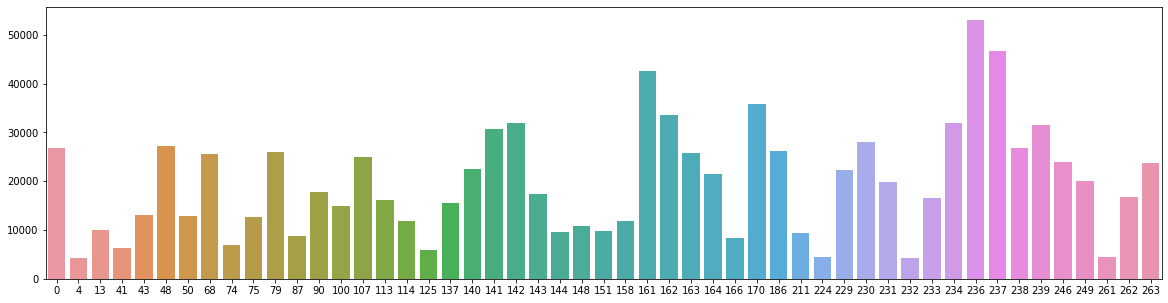

In [46]:
# SANTIAGO COMENTADO PORQUE MODIFICA DOLOCATIOKN ID - > VERRR

# # Contamos las apariciones de los lugares mas concurridos
# mostCommonSites = Counter(df['DOLocationID'])

# # Mostramos los 50 primeros.
# print(mostCommonSites.most_common(50))

# aux = mostCommonSites.most_common(50)
# most_important_places = []
# for i in aux:
#     most_important_places.append(i[0])

    
# # for i, placeValue in enumerate(df['DOLocationID']):
# #     if (not placeValue in most_important_places):
# #         df.loc[i,'DOLocationID'] = 0

# df['DOLocationID'] = np.where(df['DOLocationID'].isin(most_important_places), df['DOLocationID'], 0)

# doLocation_feature = df['DOLocationID'].value_counts()
# plt.figure(figsize=(20,5))
# sns.barplot(x=doLocation_feature.index, y=doLocation_feature.values, data=df['DOLocationID'])
# commonSites = Counter(df['DOLocationID'])
# # Mostramos los 50 primeros.
# print(commonSites.most_common(20))

In [47]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
count,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000,1009937.000
mean,1.668,1.495,1.894,1.003,166.801,163.916,1.000,9.689,1.144,0.500,2.406,0.006,0.300,15.687,2.453,816.572
std,0.471,1.144,1.447,0.101,66.936,71.137,0.000,5.081,1.238,0.012,1.571,0.247,0.002,6.180,0.340,3444.338
min,1.000,0.000,0.010,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,1.000,1.000,0.940,1.000,125.000,113.000,1.000,6.000,0.000,0.500,1.660,0.000,0.300,11.750,2.500,376.000
50%,2.000,1.000,1.500,1.000,163.000,162.000,1.000,8.500,0.500,0.500,2.160,0.000,0.300,14.160,2.500,590.000
75%,2.000,2.000,2.350,1.000,234.000,234.000,1.000,11.500,2.500,0.500,2.960,0.000,0.300,18.300,2.500,886.000
max,2.000,6.000,83.800,5.000,263.000,263.000,1.000,416.000,18.500,0.500,430.000,80.000,0.300,450.300,2.750,86396.000


<AxesSubplot:xlabel='duration', ylabel='trip_distance'>

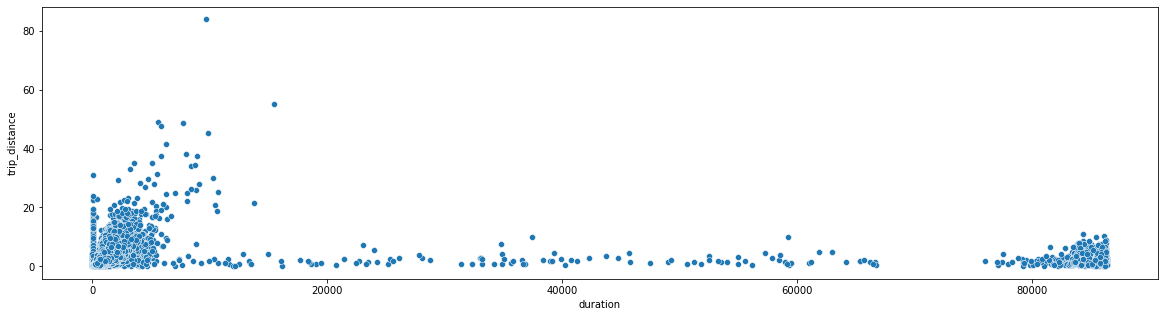

In [48]:
# Grafico de duracion de viaje vs distancia recorrida.
plt.figure(figsize=(20,5))
sns.scatterplot(x='duration', y='trip_distance', data=df)

<AxesSubplot:xlabel='trip_distance', ylabel='total_amount'>

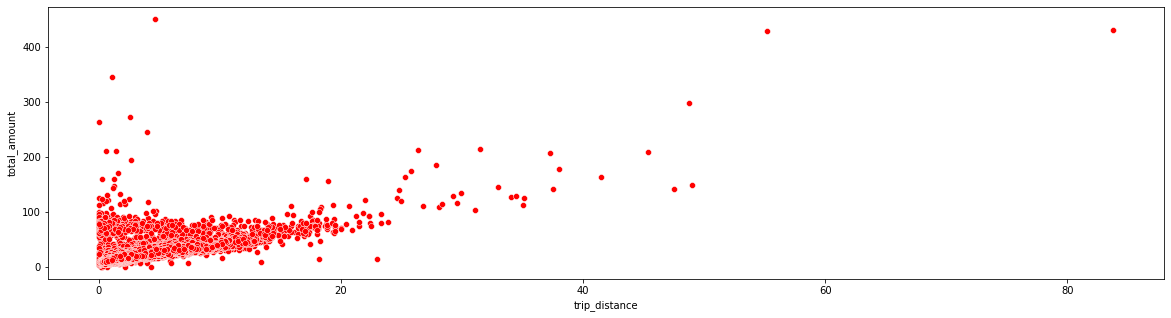

In [49]:
# Grafico de duracion de viaje vs total cobrado.
plt.figure(figsize=(20,5))
sns.scatterplot(x='trip_distance', y='total_amount', data=df, color='red')

<AxesSubplot:xlabel='trip_distance', ylabel='tip_amount'>

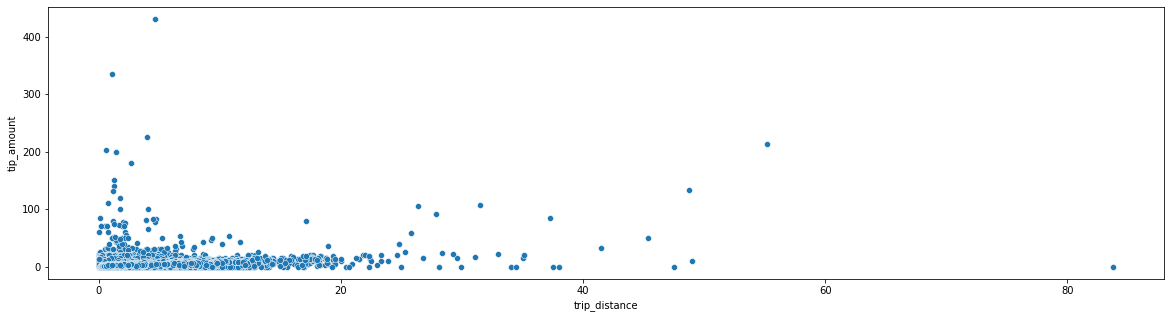

In [50]:
# Grafico de duracion de viaje vs propinas.
plt.figure(figsize=(20,5))
sns.scatterplot(x='trip_distance', y='tip_amount', data=df)

<AxesSubplot:xlabel='tip_amount', ylabel='total_amount'>

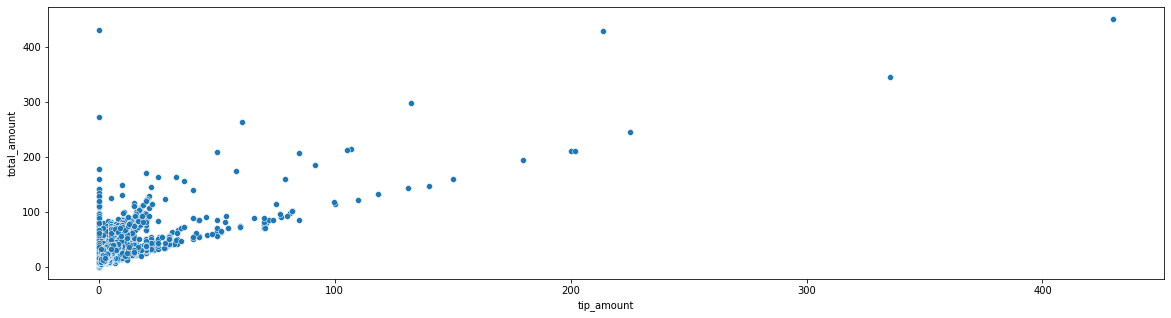

In [51]:
# Grafico de propinas vs total_cobrado.
plt.figure(figsize=(20,5))
sns.scatterplot(x='tip_amount', y='total_amount', data=df)

<AxesSubplot:xlabel='total_amount', ylabel='Count'>

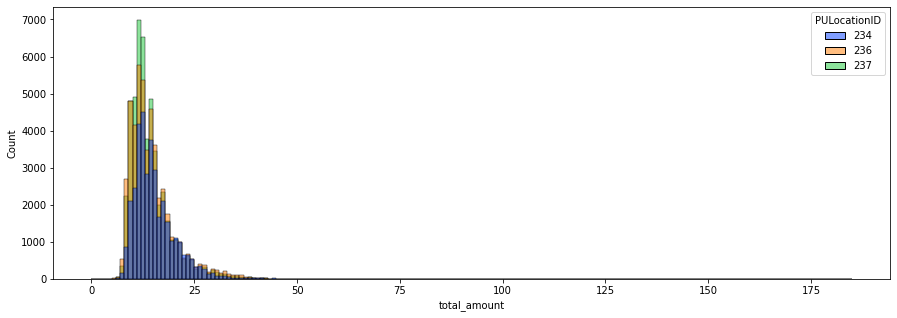

In [52]:

df_aux = df.loc[(df['PULocationID'] == 237) | (df['PULocationID'] == 236) | (df['PULocationID'] == 234)]

plt.figure(figsize=(15,5))
sns.histplot(data=df_aux, x='total_amount',hue='PULocationID', binwidth=1, palette='bright')


<AxesSubplot:xlabel='total_amount', ylabel='Count'>

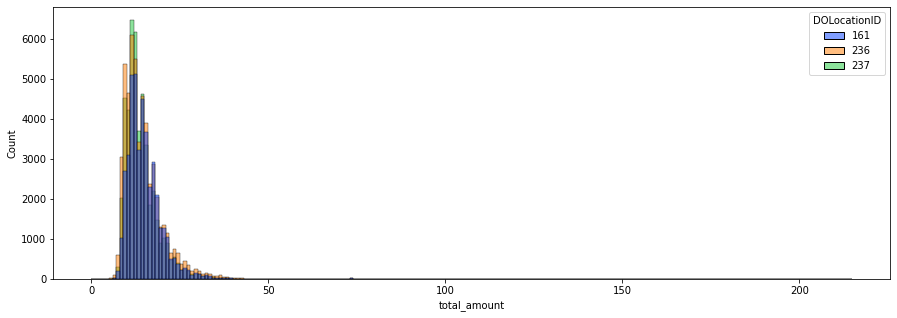

In [53]:
# Grafico de lugares donde se finalizo el viaje con mayor valor cobrado.
df_aux_do = df.loc[(df['DOLocationID'] == 237) | (df['DOLocationID'] == 236) | (df['DOLocationID'] == 161)]
plt.figure(figsize=(15,5))
sns.histplot(data=df_aux_do, x='total_amount',hue='DOLocationID', binwidth=1, palette='bright')

<AxesSubplot:xlabel='tip_amount', ylabel='Count'>

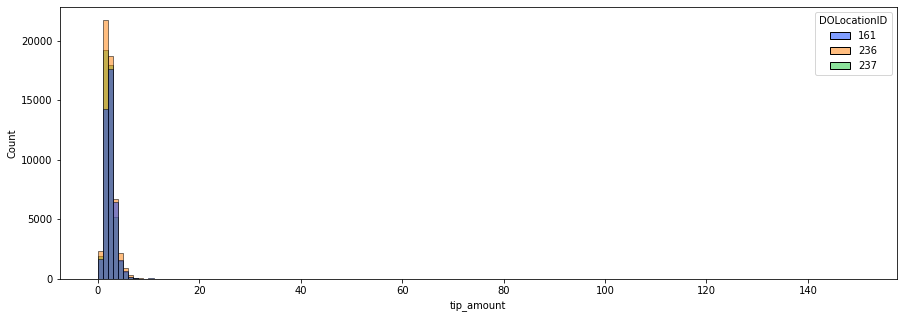

In [54]:
# Grafico de lugares donde se finalizo el viaje con mayor valor de propina.
plt.figure(figsize=(15,5))
sns.histplot(data=df_aux_do, x='tip_amount',hue='DOLocationID', binwidth=1, palette='bright')

### 2.3 Selección final de las features

En base al procesamiento anterior, seleccionamos los siguientes features del dataset:

In [68]:

feature_cols = [
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'mta_tax', 'tip_amount', 'tolls_amount', 
  'improvement_surcharge', 'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationID',
  'morning', 'afternoon', 'evening']
# target_col = ['DOLocationID']

X = df[feature_cols]
y = df['DOLocationID']

X.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration,PULocationID,morning,afternoon,evening
0,2.000,1.090,5.500,0.500,0.500,1.860,0.000,0.300,11.160,2.500,274.000,162,0,0,1
3,1.000,0.800,6.000,3.000,0.500,1.950,0.000,0.300,11.750,2.500,336.000,234,0,0,1
9,1.000,1.790,11.000,1.000,0.500,3.060,0.000,0.300,18.360,2.500,898.000,230,0,1,0
11,1.000,0.950,5.500,0.000,0.500,2.640,0.000,0.300,11.440,2.500,262.000,142,0,1,0
13,1.000,1.760,9.000,0.500,0.500,2.000,0.000,0.300,14.800,2.500,636.000,158,0,1,0


#### Eliminacion de datos con baja varianza

In [56]:
from statistics import variance
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(X)
print(X.shape)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X.columns
                    if column not in X.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))

#Constant columns names:
for column in constant_columns:
    print(column)
    
variance_X = X.drop(constant_columns,axis=1)
variance_X.shape

(1009937, 15)
(1009937, 13)
2
mta_tax
improvement_surcharge


(1009937, 13)

In [57]:
variance_X.head()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount,total_amount,congestion_surcharge,duration,PULocationID,morning,afternoon,evening
0,2.000,1.090,5.500,0.500,1.860,0.000,11.160,2.500,274.000,162,0,0,1
3,1.000,0.800,6.000,3.000,1.950,0.000,11.750,2.500,336.000,234,0,0,1
9,1.000,1.790,11.000,1.000,3.060,0.000,18.360,2.500,898.000,230,0,1,0
11,1.000,0.950,5.500,0.000,2.640,0.000,11.440,2.500,262.000,142,0,1,0
13,1.000,1.760,9.000,0.500,2.000,0.000,14.800,2.500,636.000,158,0,1,0


#### Selección de features con el coeficiente de Kendall

El coeficiente de Kendall permite analizar la correlación entre variables numéricas de entrada y una variable de salida categórica (DOLocationID). 
- Test de correlación de Kendall: 
    - Test no paramétrico, i.e. no asume ninguna distribución de los datos
    - $H_0$: Las variables son independientes, $H_1$: Las variables no son independientes.
    - Se basa en el estadístico $\tau = {\frac {2}{n(n-1)}}\sum _{i<j}{sgn}(x_{i}-x_{j}){sgn}(y_{i}-y_{j})$ 
    - Orden $n^2$, si hay muchos datos puede ser muy costoso.

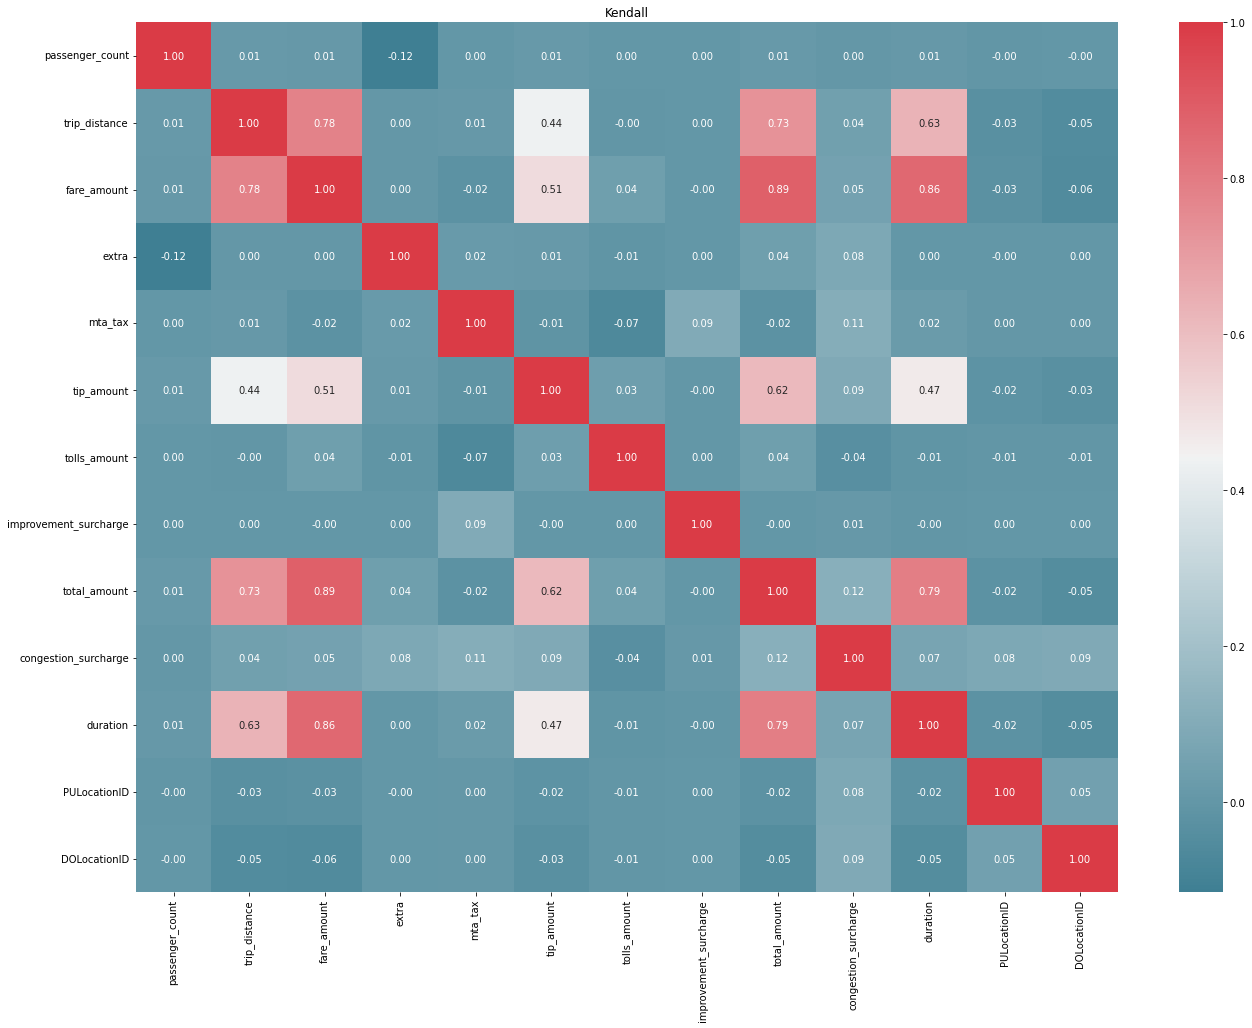

In [76]:
fig, axes = plt.subplots(1,1,figsize=(22,16))

#genero un dataframe con los features de interes solamente (X + y)
kendall_cols = list.copy(feature_cols)
kendall_cols.append('DOLocationID')
kendall_df = df[kendall_cols]
tau = kendall_df.corr(method='kendall')
axes.set_title("Kendall")
sns.heatmap(tau, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

__Conclusión__:  
Se detectan correlaciones fuertes (superior al 75%) entre los siguientes features:  
* fare_amount - trip_distance (0.78)
* total_amount - fare_amount (0.89)
* duration - fare_amount (0.86)
* duration - total_amount (0.79)

Se concluye que podría llegar a seleccionarse entre total_amount y fare_amount en lugar de avanzar con ambas dada su alto grado de correlación

## 3.Entrenamiento de modelos 
### 3.1 Separación de datos


In [ ]:
# Particionamos en train y test
train_ratio = 0.7
test_ratio = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [ ]:
#imprimo tamaños de los dataset de train y test
print(f'train len={len(X_train)}')
print(f'test len={len(X_test)}')

train len=757768
test len=252590


### 3.2 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
total_trees = 100 # number of trees
max_depth = 5

rf = RandomForestClassifier(n_estimators = total_trees, criterion = 'entropy', max_depth = max_depth, random_state=0)

In [ ]:
rf.fit(X_train, y_train.values.reshape(-1))


RandomForestClassifier(criterion='entropy', max_depth=5, random_state=0)

In [ ]:

# Utilizamos el método de predicción en los datos de prueba
y_rf_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_rf_pred))
#print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_rf_pred),4))
# rf_precision, rf_recall, rf_threshold=precision_recall_curve(y_test, y_rf_pred)
# print('Area bajo la curva Precision-Recall:',np.round(auc(rf_recall,rf_precision),4))
# plot_confusion_matrix(rf, X_test, y_test,cmap='Blues')

/opt/miniconda3/envs/pycartetEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.15      0.70      0.25      6745
           4       0.00      0.00      0.00      1096
          13       0.00      0.00      0.00      2490
          41       0.00      0.00      0.00      1522
          43       0.00      0.00      0.00      3286
          48       0.14      0.00      0.00      6825
          50       0.00      0.00      0.00      3196
          68       0.00      0.00      0.00      6432
          74       0.00      0.00      0.00      1783
          75       0.42      0.04      0.07      3186
          79       0.07      0.18      0.10      6580
          87       0.00      0.00      0.00      2236
          90       0.00      0.00      0.00      4432
         100       0.00      0.00      0.00      3801
         107       0.00      0.00      0.00      6257
         113       0.00      0.00      0.00      4033
         114       0.00      0.00      0.00      2898
         125       0.00    

<BarContainer object of 15 artists>

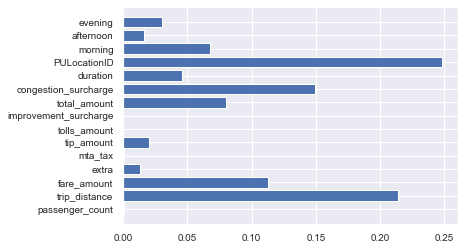

In [ ]:
#grafico los features segun su importancia
plt.barh(X_train.columns, rf.feature_importances_)

### 3.3 Regresión logística

In [ ]:
def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegressionCV(scoring='f1')
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1])
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
    print(f'Precision:{precision}, Recall: {recall}:')
    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues')

In [ ]:
scaler = StandardScaler()  
X_train_sc = scaler.fit_transform(X_train) # Estandarizamos los datos     
X_test_sc = scaler.transform(X_test)

lr = LogisticRegression(random_state = 1, max_iter=300, n_jobs=-1)
lr.fit(X_train_sc,y_train)
y_lr_pred = lr.predict(X_test_sc)
# lr_precision, lr_recall, lr_threshold=precision_recall_curve(y_test,y_lr_pred)

# lr_precision, lr_recall, lr_threshold

In [ ]:
print(classification_report(y_test,y_lr_pred))


In [ ]:
#grafico los features segun su importancia
plt.barh(X_train.columns, rf.feature_importances_)

In [ ]:
# Random Forest sin el campo Others
#df_ten_places = df[(df['duration'] >= 0)]
print(df['PULocationID'].value_counts())
print(df['DOLocationID'].value_counts())

df_ten_places = df[(df['DOLocationID'] > 0)]
df_no_pu = df_ten_places[(df_ten_places['PULocationID'] > 0)]
df_no_pu.describe()




In [ ]:
feature_cols = [
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'mta_tax', 'tip_amount', 'tolls_amount', 
  'improvement_surcharge', 'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationID',
  'morning', 'afternoon', 'evening']

X_no_other = df_no_pu[feature_cols]
y_no_other = df_no_pu['DOLocationID']



In [ ]:
y_no_other.describe()

In [ ]:
X_no_other.describe()

In [ ]:
X_train_T, X_test_T, y_train_T, y_test_T =  train_test_split(\
    X_no_other,\
    y_no_other,\
    stratify = y_no_other,\
    random_state=0)

In [ ]:
scaler = StandardScaler()  
X_train_xsc = scaler.fit_transform(X_train_T) # Estandarizamos los datos     
X_test_xsc = scaler.transform(X_test_T)

lr_T = LogisticRegression(random_state = 0, max_iter=300)
lr_T.fit(X_train_xsc,y_train_T)
y_lr_pred_T = lr_T.predict(X_test_xsc)

In [ ]:
print(classification_report(y_test_T,y_lr_pred_T))

## Automl


In [ ]:
from pycaret.classification import *
from pycaret.datasets import get_data

In [ ]:

df_automl = df[feature_cols]
df_automl['DOLocationID'] = df['DOLocationID']
clf1 = setup(df_automl, target = 'DOLocationID', log_experiment = True, experiment_name = 'tp_final', use_gpu=False, silent=True)

In [ ]:
# model training
best_model = compare_models() 

# TODO - Falta terminar

1. Aplicar filtrado Kendall para analizar las variables de entrada con respecto a la de salida
2. Analizar variables con poca varianza
3. Quedarse con las 10 Locations mas importantes de Pick Up y Drop Off y todas las otras meterlas en un id 0 (others)
4. Correr Random Forest y Linear regression. Obtener los feature importance.
5. Ejecutar pyCaret para ver en que concluye el automl